# Load calculated values and plot the statistics 
This notebook reproduces the pictures used in Fig. 12 and Fig. 13 for the following manuscript:

Yi, X., Miao, H., Lo, J.K.Y., Elsheikh, M., Lee, T.H., Jiang, C., Segelke, B.W., Overton, K.W., Bremer, P.T. and Laurence, T.A., 2022. A Tailored Approach To Study Legionella Infection Using Lattice Light Sheet Microscope (LLSM). bioRxiv. doi: https://doi.org/10.1101/2022.03.20.485032

### Datasets can be downloaded from the following data repository on figshare:
 Yi, Xiyu; Miao, Haichao; Lo, Jacky Kai-Yin; Elsheikh, Maher M.; Lee, Tek Hyung; Jiang, Chenfanfu; et al. (2022): Datasets for the manuscript titled "A Tailored Approach to Study Legionella Infection Using Lattice Light Sheet Microscope (LLSM)". figshare. Journal contribution. https://doi.org/10.6084/m9.figshare.19694809.v30 

### llsmvis repository can be found here:
https://github.com/xiyuyi-at-LLNL/llsmvis

# 1. Import tools

In [1]:
import sys
# append the directory to llsmvis to the system path following the examples below.
sys.path.append('/g/g92/miao1/Development/llsmvis')
sys.path.append('/Users/yi10/Desktop/Research/Software/T-llsmvis/')
sys.path.append('/g/g92/yi10')
sys.path.append('[add your path to the llsmvis folder]')

import llsmvis
from llsmvis.extensions import hp3d
from llsmvis.extensions.hp3d import surface_morphometrics as sm
from llsmvis.extensions.hp3d import masscenter as mc
from llsmvis.extensions.hp3d import croproi3d as c3d
from llsmvis.extensions.hp3d import tools_writeout as tools
import h5py
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support
from llsmvis.extensions.hp3d import tools_vectorsets as v
from scipy.interpolate import griddata
import copy
from scipy.stats import pearsonr

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

# 2. Aggregate datasets into 2 conditions (naive and infected macrophages)

In [2]:
fpaths=[x for x in os.listdir('/p/lscratchh/yi10/hp3d') if x.startswith('2021')] # change this path to your local data path.
# separate fpaths into 2 groups, one is naive macrophage, the other one is infected macrophage.
fpaths_naive_macr=[]
fpaths_Lg_macr_cl=[]

for i, fpath in enumerate(fpaths):
    if fpath.startswith('2021-09-'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-01'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-04'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-06'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-08'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-14'):
        fpaths_naive_macr.append(fpath)
        
    
    if fpath.startswith('2021-10-28'):
        fpaths_Lg_macr_cl.append(fpath)
    
    if fpath.startswith('2021-10-29'):
        fpaths_Lg_macr_cl.append(fpath)
    
    if fpath.startswith('2021-11-'):
        fpaths_Lg_macr_cl.append(fpath)

print(str(len(fpaths_naive_macr))+' naive macrophage cells')
print(str(len(fpaths_Lg_macr_cl))+' infected macrophage cells')



131 naive macrophage cells
101 infected macrophage cells


# 3. Load values

In [3]:
# plot polarity vector amplitude evolution per cell, and append it to the cell hdf5
# fpath=fpaths_naive_macr[0]

def load_values(fpath, showplot=False):
    cell_hdf5_path='/p/lscratchh/yi10/hp3d/'+fpath+'/hp3ddata_'+fpath+'.hdf5' # change this path to your local data path.
    print('loading '+cell_hdf5_path)
    a0s = []
    a1s = []
    a2s = []
    a3s = []
    a4s = []
    a5s = []
    a6s = []
    
    t0 = '[D14] polarity vector amplitudes'
    t1 = '[D15] polarity based on volume - negative volume std'
    t2 = '[D16] polarity based on volume - positive volume std'
    t3 = '[D17] polarity based on volume - sum of negative delta volumes'
    t4 = '[D18] polarity based on volume - sum of positive delta volumes'
    t5 = '[D19] polarity based on roughness - maxima N'
    t6 = '[D20] polarity based on roughness - minima N'

    vs=[]

    f2 = h5py.File(cell_hdf5_path, 'r')
    
    for a, t in zip([a0s,a1s,a2s,a3s,a4s,a5s,a6s],[t0,t1,t2,t3,t4,t5,t6]):
        v=np.asarray(f2[t])
        vs.append(v)
    
    f2.close()
    return vs
        

# 4. Check the data fields

You can change the corresponding datapath to your own path


In [4]:
fpath=fpaths[0]
cell_hdf5_path='/p/lscratchh/yi10/hp3d/'+fpath+'/hp3ddata_'+fpath+'.hdf5'# change this path to your local data path.
f2 = h5py.File(cell_hdf5_path, 'a')
for a in f2.keys():
    print(a)
f2.close()

[D10] volume values
[D11] surface area values
[D12] sphere radius with equi volume
[D13] sphere radius with equi surface area
[D14] polarity vector amplitudes
[D15] polarity based on volume - negative volume std
[D16] polarity based on volume - positive volume std
[D17] polarity based on volume - sum of negative delta volumes
[D18] polarity based on volume - sum of positive delta volumes
[D19] polarity based on roughness - maxima N
[D1] mass centers
[D20] polarity based on roughness - minima N
[D2] threshold saddle point
[D3] threshold saddle point index
[D4] threshold upper bound
[D5] threshold upper bound index
[D6] threshold lower bound
[D7] threshold lower bound index
[D8] threshold cell peripheral lower bound
[D9] volume centers
[G01] voxel value bin centers
[G02] voxel value histogram counts
[G03] stack XY mips before cropping
[G04] stack YZ mips before cropping
[G05] stack XZ mips before cropping
[G06] stack XY mips after cropping - saddle point to upper bound
[G07] stack YZ mip

# 5. Organize the data valuse over all datasets

In [5]:
import copy

In [6]:
# organize for naive macrophage cells

tag=0
vs=load_values(fpaths_naive_macr[0], showplot=False)
vs[1] = np.linalg.norm(vs[1],axis=1)
vs[2] = np.linalg.norm(vs[2],axis=1)
l=copy.deepcopy(vs);
for fpath in fpaths_naive_macr[1:]:
    try:
        vs=load_values(fpath, showplot=False)
        vs[1] = np.linalg.norm(vs[1],axis=1)
        vs[2] = np.linalg.norm(vs[2],axis=1)
        l=np.concatenate([l,vs],axis=1)    
        tag+=1
    except:
        pass

values_for_naive_macrophage=copy.deepcopy(l)

loading /p/lscratchh/yi10/hp3d/2021-09-24-cell7/hp3ddata_2021-09-24-cell7.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-14-cell1/hp3ddata_2021-10-14-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-14-cell16/hp3ddata_2021-10-14-cell16.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-01-cell5/hp3ddata_2021-10-01-cell5.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-24-cell16/hp3ddata_2021-09-24-cell16.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-30-cell4/hp3ddata_2021-09-30-cell4.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell4/hp3ddata_2021-10-04-cell4.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-22-cell20/hp3ddata_2021-09-22-cell20.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell12/hp3ddata_2021-10-04-cell12.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell18/hp3ddata_2021-10-04-cell18.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-29-cell0/hp3ddata_2021-09-29-cell0.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-30-cell11/hp3ddata_2021-09-30-cell11.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-0

loading /p/lscratchh/yi10/hp3d/2021-09-24-cell8/hp3ddata_2021-09-24-cell8.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-14-cell4/hp3ddata_2021-10-14-cell4.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-24-cell2/hp3ddata_2021-09-24-cell2.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-27-cell6/hp3ddata_2021-09-27-cell6.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-08-cell1/hp3ddata_2021-10-08-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell25/hp3ddata_2021-10-04-cell25.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-30-cell1/hp3ddata_2021-09-30-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-22-cell25/hp3ddata_2021-09-22-cell25.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell1/hp3ddata_2021-10-04-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell17/hp3ddata_2021-10-04-cell17.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-29-cell5/hp3ddata_2021-09-29-cell5.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-06-cell2/hp3ddata_2021-10-06-cell2.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell

In [7]:
# organize for infected macrophage cells

tag=0
vs=load_values(fpaths_Lg_macr_cl[0], showplot=False)
vs[1] = np.linalg.norm(vs[1],axis=1)
vs[2] = np.linalg.norm(vs[2],axis=1)
l=copy.deepcopy(vs);
for fpath in fpaths_Lg_macr_cl[1:]:
    vs=load_values(fpath, showplot=False)
    vs[1] = np.linalg.norm(vs[1],axis=1)
    vs[2] = np.linalg.norm(vs[2],axis=1)
    l=np.concatenate([l,vs],axis=1)    
    tag+=1

values_for_Lg_macrophage=copy.deepcopy(l)

loading /p/lscratchh/yi10/hp3d/2021-11-04-cell7/hp3ddata_2021-11-04-cell7.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-28-cell3/hp3ddata_2021-10-28-cell3.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-02-cell2/hp3ddata_2021-11-02-cell2.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-11-cell3/hp3ddata_2021-11-11-cell3.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-11-cell9/hp3ddata_2021-11-11-cell9.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-17-cell6/hp3ddata_2021-11-17-cell6.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-09-cell0/hp3ddata_2021-11-09-cell0.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-12-cell7/hp3ddata_2021-11-12-cell7.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-10-cell4/hp3ddata_2021-11-10-cell4.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-09-cell12/hp3ddata_2021-11-09-cell12.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-11-cell10/hp3ddata_2021-11-11-cell10.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-04-cell12/hp3ddata_2021-11-04-cell12.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-05-cell

In [8]:
# simplify variables

v1=values_for_naive_macrophage
v2=values_for_Lg_macrophage

# 6. Plot histograms shown in Fig. 12(a)(b) and Fig.13(a)(b)(c)

In [9]:
def plot_histogram(k1,k2,ttstr,bs=[]):
    [a1, b1] = np.histogram(k1, bins=bs, density=True)
    plt.plot((b1[1:]+b1[:-1])/2, a1*(b1[1]-b1[0]), 'k', linewidth=2)
    [a2, b2] = np.histogram(k2, bins=bs,density=True)
    plt.plot((b2[1:]+b2[:-1])/2, a2*(b2[1]-b2[0]), 'r', linewidth=2)
    plt.title(ttstr)

<Figure size 720x720 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 720x720 with 0 Axes>

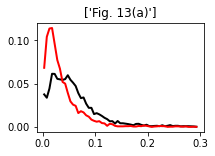

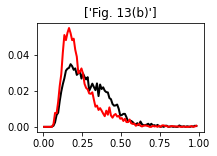

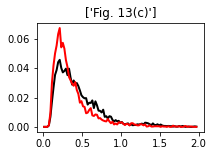

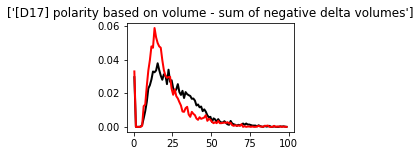

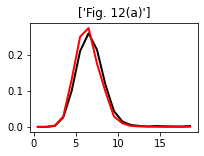

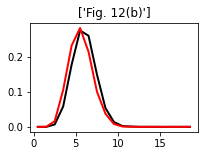

In [10]:
# check statistics [D14 - D20]
t1=['Fig. 13(a)']#['[D14] polarity vector amplitudes']
t2=['Fig. 13(b)']#['[D15] polarity based on volume - negative volume std']
t3=['Fig. 13(c)']#['[D16] polarity based on volume - positive volume std']
t4=['[D17] polarity based on volume - sum of negative delta volumes']
t5=['[D18] polarity based on volume - sum of positive delta volumes']
t6=['Fig. 12(a)']#['[D19] polarity based on roughness - maxima N']
t7=['Fig. 12(b)']#['[D20] polarity based on roughness - minima N']
ts=[t1, t2, t3, t4, t5, t6, t7]

defined_bins=[]
defined_bins.append(np.arange(0,0.3,0.005))
defined_bins.append(np.arange(0,1,0.01))
defined_bins.append(np.arange(0,2,0.02))
defined_bins.append(np.arange(0,100,1))
defined_bins.append(np.arange(0,100,1))
defined_bins.append(np.arange(0,20,1))
defined_bins.append(np.arange(0,20,1))

plt.figure(figsize=(10,10))
tag=1
for io in [1,2,3,4,6,7]:
    i=io-1
    ttstr=ts[i]
    # for i, ttstr in enumerate([t1,t2,t3,t4,t6,t7]):
    k1=v1[i,:]
    k2=v2[i,:]
    k1=k1[~np.isnan(k1)]
    k2=k2[~np.isnan(k2)]
    
    plt.figure(figsize=(3,2))
    plot_histogram(k1,k2,ttstr,bs=defined_bins[i])
    tag+=1

# 7. Calculate autocorrlelations shown in Fig. 12(c)(d) and Fig. 13(d)(e)(f)

In [11]:
# define tools
def get_AC_pearson(data):
    ac=np.zeros([len(data)-1,1])
    if sum(np.isnan(data))>0:
        ac[0]=np.nan
    else:
        ac[0], _ = pearsonr(data, data);
        
    for dt in np.arange(len(data)-2)+1:
        data1=data[dt:]
        data2=data[:-dt]
        if sum(np.isnan(data1)) + sum(np.isnan(data2)) > 0:
            ac[dt] = np.nan
        else:
            ac[dt],  _ =pearsonr(data1, data2);
        
    return ac

def get_group_AC_pearson(v_col, colN):
    arr=v_col.reshape(colN,50)
    corrs = np.zeros([colN,49]);
    for ind in np.arange(colN):
        data=arr[ind,:];
        corr=get_AC_pearson(data)
        corrs[ind,:]=corr.ravel()
    return corrs
    
def plot_group_and_signle_weith_ebar(corrs, ttstr, colorstr, markerstr):
    plt.figure(figsize=(10,5))
    for i0 in np.arange(corrs.shape[0]):
        plt.plot(corrs[i0,:])
    plt.figure(figsize=(10,5))
    plt.errorbar(np.arange(49), 
                 np.mean(corrs,axis=0), 
                 marker=markerstr,
                 color=colorstr,
                 yerr=np.std(corrs,axis=0), 
                 xerr=None)
    plt.title(ttstr)

def plot_group_and_signle_weith_ebar_pair(corrs1, coors2, ttstr, colorstrs, markerstrs, plotindivs=True, xlims=[0,20]):
    if plotindivs:
        plt.figure(figsize=(6,3))
        for i0 in np.arange(corrs1.shape[0]):
            plt.plot(corrs1[i0,:])
        for i0 in np.arange(corrs2.shape[0]):
            plt.plot(corrs2[i0,:])
    plt.figure(figsize=(6,3))
    
    plt.errorbar(np.arange(49), np.nanmean(corrs1,axis=0), 
                 marker=markerstrs[0],color=colorstrs[0],
                 yerr=np.nanstd(corrs1,axis=0)/np.sqrt(np.nansum(~np.isnan(corrs1),axis=0)), xerr=None, linewidth=2)
    plt.errorbar(np.arange(49), np.nanmean(corrs2,axis=0), 
                 marker=markerstrs[1],color=colorstrs[1],
                 yerr=np.nanstd(corrs2,axis=0)/np.sqrt(np.nansum(~np.isnan(corrs2),axis=0)), xerr=None, linewidth=2)
    plt.title(ttstr)
    plt.xlim(xlims)

def plot_group_and_signle_weith_fill_between(corrs1, coors2, ttstr, colorstrs, markerstrs, plotindivs=True, 
                                             xlims=[0,20],figsize=(6,2),picname='pic.png'):
    if plotindivs:
        plt.figure(figsize=(6,3))
        for i0 in np.arange(corrs1.shape[0]):
            plt.plot(corrs1[i0,:])
        for i0 in np.arange(corrs2.shape[0]):
            plt.plot(corrs2[i0,:])
    fig=plt.figure(figsize=figsize)
    
    y1=np.nanmean(corrs1, axis=0)
    y1a=copy.deepcopy(np.nanmean(corrs1,axis=0)+np.nanstd(corrs1,axis=0)/np.sqrt(np.nansum(~np.isnan(corrs1),axis=0)))
    y1b=copy.deepcopy(np.nanmean(corrs1,axis=0)-np.nanstd(corrs1,axis=0)/np.sqrt(np.nansum(~np.isnan(corrs1),axis=0)))
    
    plt.fill_between(np.arange(49), y1a, y1b, 
                 color=colorstrs[0],alpha=0.2)
    plt.plot(np.arange(49), y1,
             color=colorstrs[0],linewidth=1)
    
    y2=np.nanmean(corrs2,axis=0)
    y2a=copy.deepcopy(np.nanmean(corrs2,axis=0)+np.nanstd(corrs2,axis=0)/np.sqrt(np.nansum(~np.isnan(corrs2),axis=0)))
    y2b=copy.deepcopy(np.nanmean(corrs2,axis=0)-np.nanstd(corrs2,axis=0)/np.sqrt(np.nansum(~np.isnan(corrs2),axis=0)))
    
    plt.fill_between(np.arange(49), y2a, y2b, 
                 color=colorstrs[1],alpha=0.2)
    
    plt.plot(np.arange(49), y2,
             color=colorstrs[1],linewidth=1)
    plt.title(ttstr)
    plt.xlim(xlims)
    plt.ylim([-0.2,1.1])
    plt.xticks(np.arange(xlims[0],xlims[1]+1,5))
    plt.yticks([-0.2,0.0,0.2,0.6,1.0])
    # mark the zero line with dashed line
    plt.plot(xlims,[0,0],'k--', linewidth=1)
    fig.savefig(picname,dpi=300)

/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/pytho

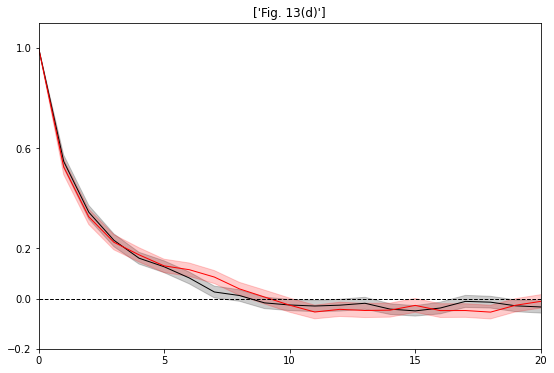

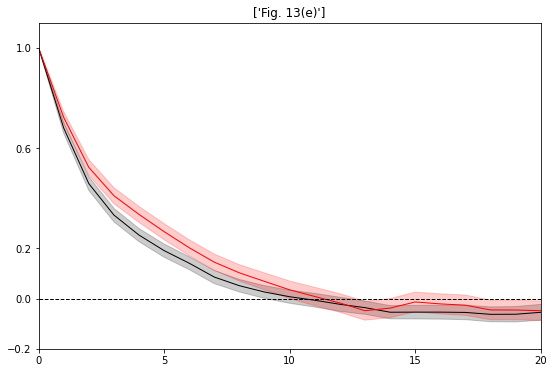

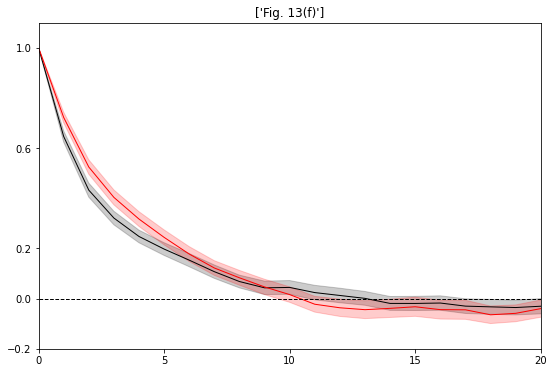

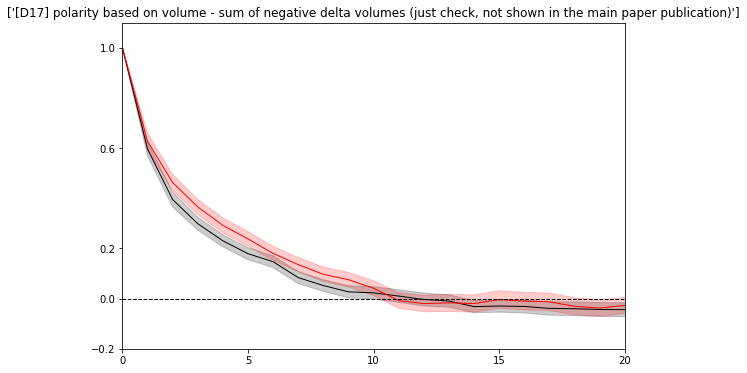

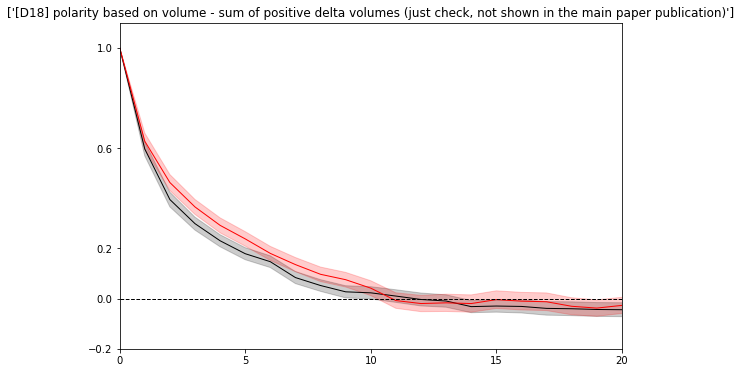

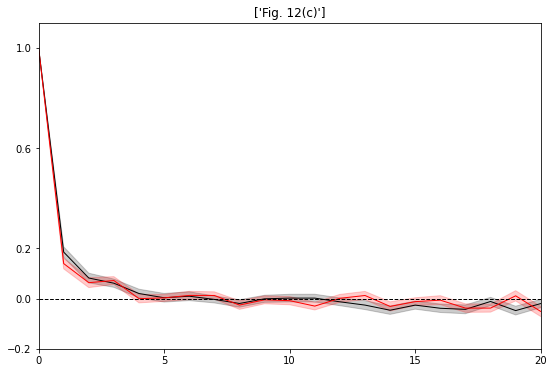

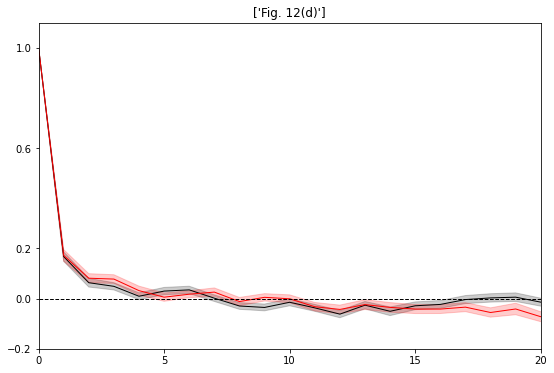

In [12]:
# calculate and plot the AC curves.
t1=['Fig. 13(d)']#['[D14] polarity vector amplitudes']
t2=['Fig. 13(e)']#['[D15] polarity based on volume - negative volume std']
t3=['Fig. 13(f)']#['[D16] polarity based on volume - positive volume std']
t4=['[D17] polarity based on volume - sum of negative delta volumes (just check, not shown in the main paper publication)']
t5=['[D18] polarity based on volume - sum of positive delta volumes (just check, not shown in the main paper publication)']
t6=['Fig. 12(c)']#['[D19] polarity based on roughness - maxima N']
t7=['Fig. 12(d)']#['[D20] polarity based on roughness - minima N']
ts=[t1, t2, t3, t4, t5, t6, t7]

for ind in np.arange(7):
# for ind in [1]:
    corrs1 = get_group_AC_pearson(v_col = v1[ind,:], colN = 131)
    corrs2 = get_group_AC_pearson(v_col = v2[ind,:], colN = 101)
    plot_group_and_signle_weith_fill_between(corrs1, corrs2,
                                          ttstr=ts[ind],
                                          colorstrs=['k', 'r'],
                                          markerstrs=['.', '.'],
                                          plotindivs=False, figsize=(9,6))

/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/pytho

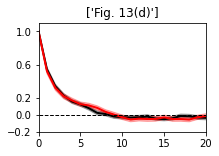

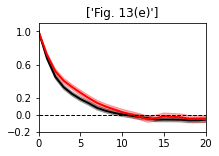

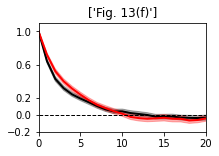

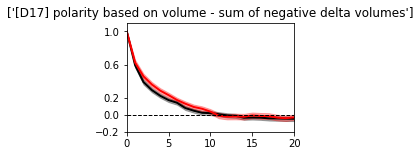

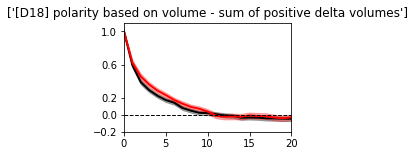

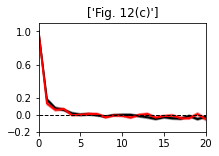

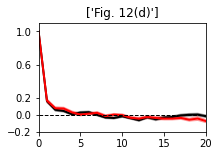

In [123]:
# calculate and plot the AC curves on smaller figure panels to be used in the manuscript

for ind in np.arange(7):
# for ind in [1]:
    corrs1=get_group_AC_pearson(v_col=v1[ind,:], colN=131)
    corrs2=get_group_AC_pearson(v_col=v2[ind,:], colN=101)
    plot_group_and_signle_weith_fill_between(corrs1, corrs2,
                                          ttstr=ts[ind],
                                          colorstrs=['k','r'],
                                          markerstrs=['.','.'],
                                          plotindivs=False, figsize=[3,2])

/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/g/g92/yi10/anaconda3/envs/llsmvis/lib/pytho

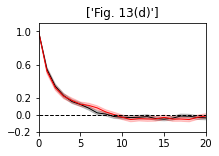

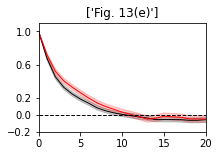

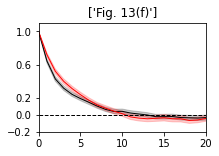

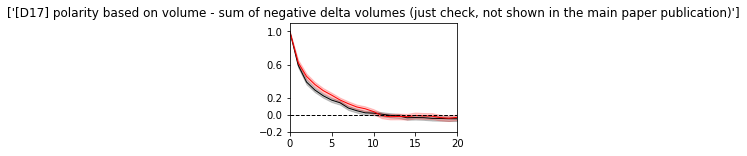

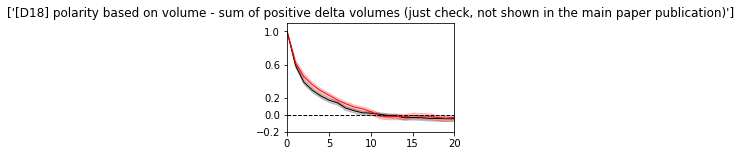

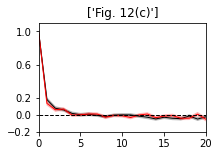

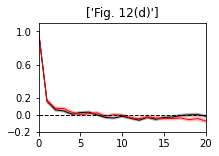

In [13]:
# calculate and plot the AC curves to be used in the manuscript (smaller panelsß)
t1=['Fig. 13(d)']#['[D14] polarity vector amplitudes']
t2=['Fig. 13(e)']#['[D15] polarity based on volume - negative volume std']
t3=['Fig. 13(f)']#['[D16] polarity based on volume - positive volume std']
t4=['[D17] polarity based on volume - sum of negative delta volumes (just check, not shown in the main paper publication)']
t5=['[D18] polarity based on volume - sum of positive delta volumes (just check, not shown in the main paper publication)']
t6=['Fig. 12(c)']#['[D19] polarity based on roughness - maxima N']
t7=['Fig. 12(d)']#['[D20] polarity based on roughness - minima N']
ts=[t1, t2, t3, t4, t5, t6, t7]
for ind in np.arange(7):
# for ind in [1]:
    corrs1=get_group_AC_pearson(v_col=v1[ind,:], colN=131)
    corrs2=get_group_AC_pearson(v_col=v2[ind,:], colN=101)
    plot_group_and_signle_weith_fill_between(corrs1, corrs2,
                                          ttstr=ts[ind],
                                          colorstrs=['k','r'],
                                          markerstrs=['.','.'],
                                          plotindivs=False, figsize=(3,2),
                                            picname='pic'+str(ind)+'.png')

# Check the number of NaN values from the datasets

In [27]:
number_nan=np.sum(np.isnan(v1))
percentage=number_nan/np.prod(v1.shape)*100
print(str(percentage)+'% of the measurements from naive macrophages are nan')

0.8418756815703381% of the measurements from naive macrophages are nan


In [28]:
number_nan=np.sum(np.isnan(v2))
percentage=number_nan/np.prod(v2.shape)*100
print(str(percentage)+'% of the measurements from infected macrophages are nan')

0.9391796322489392% of the measurements from infected macrophages are nan
